In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
data = pd.read_csv("imageFilenames.csv")
data.head()

,Unnamed: 0,totPurchaseAmt,mediumImageLink,imgFilepath
0,0,152000.0,https://photos.zillowstatic.com/p_c/IS1fwt0hhf...,images/img_0.jpg
1,1,198000.0,https://www.zillowstatic.com/static/images/nop...,no photo
2,2,130000.0,https://www.zillowstatic.com/static/images/nop...,no photo
3,3,415000.0,https://photos.zillowstatic.com/p_c/IS72penoji...,images/img_3.jpg
4,4,329900.0,https://www.zillowstatic.com/static/images/nop...,no photo


In [2]:
from PIL import Image
import numpy as np

# Want to know how we should format the height x width image data dimensions
# for inputting to a keras model
def get_size_statistics(data):
    heights = []
    widths = []
    img_count = 0
    for i, row in data.iterrows():
        if row["imgFilepath"] != "no photo" or row["imgFilepath"] != np.nan:
            try:
                imgData = np.array(Image.open(row["imgFilepath"]))
                heights.append(imgData.shape[0])
                widths.append(imgData.shape[1])
                img_count += 1
            except:
                data.at[i, "imgFilepath"] = "no photo"
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

get_size_statistics(data)

Average Height: 234.0
Max Height: 234
Min Height: 234


Average Width: 316.0
Max Width: 316
Min Width: 316


In [3]:
noPhotoIndx = data[data["imgFilepath"] == "no photo"].index 

data.drop(noPhotoIndx, inplace=True)

incorrectPrice = data[data["totPurchaseAmt"] < 70000].index

data.drop(incorrectPrice, inplace=True)

In [4]:
data.shape

(13239, 4)

In [5]:
data.describe()

,Unnamed: 0,totPurchaseAmt
count,13239.000000,1.323900e+04
mean,11482.964423,3.052358e+05
std,6845.360748,2.651797e+05
min,0.000000,7.000000e+04
25%,5507.500000,2.090000e+05
50%,11126.000000,2.650000e+05
75%,17484.500000,3.550000e+05
max,23621.000000,2.260000e+07


In [6]:
data["amtBucket"] = pd.qcut(data["totPurchaseAmt"], 10)

In [7]:
data.head()

,Unnamed: 0,totPurchaseAmt,mediumImageLink,imgFilepath,amtBucket
0,0,152000.0,https://photos.zillowstatic.com/p_c/IS1fwt0hhf...,images/img_0.jpg,"(69999.999, 164900.0]"
3,3,415000.0,https://photos.zillowstatic.com/p_c/IS72penoji...,images/img_3.jpg,"(383000.0, 469900.0]"
5,5,262000.0,https://photos.zillowstatic.com/p_c/ISv0c2glts...,images/img_5.jpg,"(242000.0, 265000.0]"
6,6,280000.0,https://photos.zillowstatic.com/p_c/ISnyo4qr43...,images/img_6.jpg,"(265000.0, 293500.0]"
7,7,237000.0,https://photos.zillowstatic.com/p_c/ISzyrqwit7...,images/img_7.jpg,"(220000.0, 242000.0]"


In [8]:
data["amtBucket"].value_counts()

(242000.0, 265000.0]      1378
(164900.0, 195000.0]      1332
(69999.999, 164900.0]     1332
(330660.0, 383000.0]      1331
(220000.0, 242000.0]      1326
(293500.0, 330660.0]      1323
(383000.0, 469900.0]      1321
(469900.0, 22600000.0]    1320
(195000.0, 220000.0]      1314
(265000.0, 293500.0]      1262
Name: amtBucket, dtype: int64

In [9]:
bucketList = list(data["amtBucket"].unique())
print(bucketList)
data["amtBucketNum"] = [bucketList.index(i) for i in data["amtBucket"]]

[Interval(69999.999, 164900.0, closed='right'), Interval(383000.0, 469900.0, closed='right'), Interval(242000.0, 265000.0, closed='right'), Interval(265000.0, 293500.0, closed='right'), Interval(220000.0, 242000.0, closed='right'), Interval(469900.0, 22600000.0, closed='right'), Interval(330660.0, 383000.0, closed='right'), Interval(195000.0, 220000.0, closed='right'), Interval(293500.0, 330660.0, closed='right'), Interval(164900.0, 195000.0, closed='right')]


In [10]:
data.head()

,Unnamed: 0,totPurchaseAmt,mediumImageLink,imgFilepath,amtBucket,amtBucketNum
0,0,152000.0,https://photos.zillowstatic.com/p_c/IS1fwt0hhf...,images/img_0.jpg,"(69999.999, 164900.0]",0
3,3,415000.0,https://photos.zillowstatic.com/p_c/IS72penoji...,images/img_3.jpg,"(383000.0, 469900.0]",1
5,5,262000.0,https://photos.zillowstatic.com/p_c/ISv0c2glts...,images/img_5.jpg,"(242000.0, 265000.0]",2
6,6,280000.0,https://photos.zillowstatic.com/p_c/ISnyo4qr43...,images/img_6.jpg,"(265000.0, 293500.0]",3
7,7,237000.0,https://photos.zillowstatic.com/p_c/ISzyrqwit7...,images/img_7.jpg,"(220000.0, 242000.0]",4


In [11]:
IMG_SIZE = 224

def resizeAndLoadData(data):
    imageData = []
    for i, row in data.iterrows():
        img = Image.open(row["imgFilepath"])
        img = img.resize((IMG_SIZE, IMG_SIZE))
        imageData.append(np.array(img))
    data["imgData"] = imageData

resizeAndLoadData(data)

In [12]:
data.head(1)

,Unnamed: 0,totPurchaseAmt,mediumImageLink,imgFilepath,amtBucket,amtBucketNum,imgData
0,0,152000.0,https://photos.zillowstatic.com/p_c/IS1fwt0hhf...,images/img_0.jpg,"(69999.999, 164900.0]",0,"[[[183, 209, 237], [179, 207, 236], [169, 199,..."


In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X = np.array(data["imgData"])
#y = to_categorical(data["amtBucketNum"], num_classes=len(bucketList))
y = data["totPurchaseAmt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using TensorFlow backend.


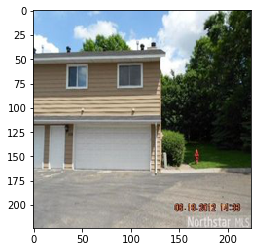

In [14]:
import matplotlib.pyplot as plt
plt.imshow(X[0])

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [25]:
from keras import applications

vggModel = Sequential()

vggModel.add(applications.VGG16(weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False))

numLayers = len(vggModel.layers)

for layer in vggModel.layers[:numLayers-2]:
    layer.trainable = False


vggModel.add(Flatten(input_shape=vggModel.output_shape[1:]))
vggModel.add(Dropout(.1))
vggModel.add(Dense(1, activation="linear"))

vggModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 14,739,777
Non-trainable params: 0
_________________________________________________________________


In [26]:
vggModel.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])

In [27]:
X_train = np.array([i for i in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

vggModel.fit(X_train, y_train, batch_size=50, epochs=500, verbose=1, validation_split=0.1)

Train on 9531 samples, validate on 1060 samples
Epoch 1/100
9531/9531 [==============================] - 235s 25ms/step - loss: 187060965256.6354 - mae: 167457.5938 - val_loss: 32443519613.5849 - val_mae: 99869.9297
Epoch 2/100
9531/9531 [==============================] - 255s 27ms/step - loss: 86312542457.3656 - mae: 116546.9062 - val_loss: 31042263329.8113 - val_mae: 116054.2188
Epoch 3/100
9531/9531 [==============================] - 268s 28ms/step - loss: 84689359709.5524 - mae: 113725.0938 - val_loss: 30664269205.7358 - val_mae: 97111.8516
Epoch 4/100
9531/9531 [==============================] - 271s 28ms/step - loss: 84677845015.2068 - mae: 115204.4219 - val_loss: 30422177193.0566 - val_mae: 96191.2344
Epoch 5/100
9531/9531 [==============================] - 272s 29ms/step - loss: 83073924789.5180 - mae: 110925.8516 - val_loss: 66849177831.8491 - val_mae: 195166.7031
Epoch 6/100
9531/9531 [==============================] - 271s 28ms/step - loss: 84317457027.6664 - mae: 113823.882

KeyboardInterrupt: 

In [29]:
X_test = np.array([i for i in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

loss, mae = vggModel.evaluate(X_test, y_test, verbose=1)

print("Loss (MSE): ", loss)
print("MAE: ", mae)

2648/2648 [==============================] - 23s 9ms/step
Loss (MSE):  41715903664.33837
MAE:  98037.6640625


In [ ]:
vggModel.save("ZillowCNN.h5")